<h1 style="color:#555; font-size:3em;">Transfer Learning Experiments Ordered</h1>

In [227]:
from time import time
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import models, datasets, transforms
from torchsummary import summary

from models.inception_resnet_v1 import InceptionResnetV1

In [228]:
state_dict_unalt = InceptionResnetV1().state_dict().copy()

# 1. Loading the data

In [229]:
data_trans = transforms.Compose([
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.ToTensor()
])

data_set_all = datasets.ImageFolder("./data/classified_crops/",transform=data_trans)
data_set_all

Dataset ImageFolder
    Number of datapoints: 128
    Root location: ./data/classified_crops/
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=None)
               ToTensor()
           )

## 1.1 Create a striated split dataloader

In [267]:
targets = np.array(data_set_all.targets)
idx = train_test_split(torch.arange(len(targets)), shuffle=True, stratify=targets, random_state=34, test_size=0.2)

g = np.gcd(len(idx[0]),len(idx[1])) 
batch_size = g if g > 4 and g < 16 else 5

sets = ['train', 'valid']
tr, va = sets

indices = { x:idx[i] for i,x in enumerate(sets) }
samplers = { x:SubsetRandomSampler(indices[x]) for x in sets }
dataloaders = { x:DataLoader(data_set_all,int(batch_size),sampler=samplers[x],drop_last=True) for x in sets }

___
# 2. Distance based loss function
- Loss functon will work only with a batch.
- Will take the n-dim vector representation of images and the labels.
- Then calculate the distance between each other.
- If the labels match the distance should be less.
- If the labels don't match the distance should be more.  

**Note -**
Pairwise distance is the generalization of euclidean distance
i.e. when p = 2, pairwise distance == euclidean distance.

In [345]:
class DistLoss:
    def __init__(self,sim_thresh=0.2, dis_offset=0.3, eps=1.2, \
                 dist_func=nn.PairwiseDistance(p=2,eps=1e-8)):
        """
        sim_thresh: distance below which loss doesn't increase if same class.
        dis_offset: 1 + dis_offset, below which loss increases is !same class.
        eps: factor to raise the dissimilar term by.
        dis_func: function to calculate distance between two vectors.
        """
        self.sim_thresh = sim_thresh
        self.dis_offset = dis_offset
        self.eps = eps
        self.dist_func = dist_func
        
    def dist_calculator(self, x1, x2):
        """
        Function that calculates the distances between
        all the vectors in x1 and x2 which are of the
        shape (m1,n) and (m2,n).

        n: dimensions in vector
        m1, m2: co-ordinates in x1 and x2 

        returns: (m2,m1) shape distance matrix
        """
        dists = []
        for vec in x1:
            dists.append(self.dist_func(x2,vec))
        return torch.stack(dists)   
    
    def __call__(self, y_vectors:"vectors from the model", y:"labels", \
                  dist_calculator=calc_all_dist, sim_thresh=0.2, dis_offset=0.3, eps=1.2):
        """
        Loss function to be used if the output of the model is 
        an image embedding and the class of the image is known.

        Calculates the distance between all the y_vectors.
        If the classes match the distance > sim_thresh increases the loss 
        If the classes don't match the distance > 1 + dis_offset decreases loss
        """
        
        dist_calculator = self.dist_calculator
        sim_thresh = self.sim_thresh
        dis_offset = self.dis_offset
        eps = self.eps

        l = y_vectors.size(0)

        # Distance between all the y_vectors shape:(l,l)
        dist_matrix = dist_calculator(y_vectors, y_vectors)

        # Creating a shape:(l,l) mask using labels
        y_cross = y.repeat(l).reshape(l,l)
        y_mask = torch.eq(y_cross, y_cross.T)

        # mean tensor of dissimilar classes distances
        dis_mean = dist_matrix[~y_mask].mean()

        # Negating the diagonal cause that dist will be (almost) 0
        temp_tensor = torch.arange(l)
        y_mask[temp_tensor,temp_tensor] = False

        # mean tensor of similar classes distances
        sim_mean = dist_matrix[y_mask].mean()


        nume = sim_mean if sim_mean > sim_thresh else 0.
        deno = dis_mean - dis_offset if dis_mean < (1 + dis_offset) else 1.

        # Calculating the loss
        loss = (nume + (1./deno - 1.)**eps)
        return loss if loss > 0 else (sim_mean/dis_mean)

___
# 3. Fit Functions

In [233]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 3.1 Standard fit function
Uses a standard loss function (class based)

In [234]:
def std_fit(model, optim, loss_func, train_dl, valid_dl, epochs=25):
    start = time()
    time_st = lambda x: f"{x//60:0.0f} m {x%60:0.3f} s"
    model = model.to(device)
    losses_tr = []
    losses_va = []
    
    tr = 'train'
    va = 'valid'
    data = {tr:train_dl, va: valid_dl}
    data_count = {tr: len(train_dl.dataset), va: len(valid_dl.dataset)}
    print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
    best_accu = 0.0
    least_loss = 20
    best_model_state_dict = model.state_dict()
    
    # Add timer
    for epoch in range(epochs): 
        e_start = time()
        
        print(f"\nEPOCH: ({epoch + 1}/{epochs})\t{e_start - start:0.3f} s\n","-"*20) 
        for phase in [tr, va]:
            p_start = time()
            
            is_tr = phase == tr
            is_va = phase == va
            
            if is_tr:
                model.train()
            else:
                model.eval()
             
            """
            Loss and accuracy calculated 
            during a single epoch.
            """
            running_loss = 0.
            running_accu = 0
            
            for batch in data[phase]:
                X, y = batch
                X = X.to(device)
                y = y.to(device)
                
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):  
                    y_val = model(X)
                    y_cls = torch.argmax(y_val, dim=1)
                
                    loss = loss_func(y_val, y)
                
                    if is_tr:
                        loss.backward()
                        optim.step()
                
                """
                Running Loss:
                    Loss calculated over the entire dataset,
                    for one epoch. Loss for an epoch will be 
                    running loss divided by the total number
                    of samples (not batches).
                Running Accuracy:
                    Number of samples the model got right.
                    
                """
                samp_loss = loss.item() * len(y)
                if is_tr:
                    losses_tr.append(samp_loss)
                else:
                    losses_va.append(samp_loss)
                    
                running_loss += samp_loss
                running_accu += torch.sum(y_cls == y).item()
            
            p_time = time() - p_start
            epoch_loss = running_loss / data_count[phase]
            epoch_accu = running_accu / data_count[phase]
            print(f"{phase}: loss {epoch_loss:0.3f}, accu {epoch_accu:0.3f}, time {time_st(p_time)}")
            
            if is_va and (epoch_accu > best_accu) or (epoch_accu == best_accu and least_loss > epoch_loss):
                best_accu = epoch_accu
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
            elif is_va and least_loss > epoch_loss:
                least_loss = epoch_loss                           
     
    tot_time = time() - start
    print(f"\nTime taken: {time_st(tot_time)}, Best accuracy: {best_accu:0.3f}") 
    return model.load_state_dict(best_model_state_dict), losses_tr, losses_va

## 3.2 Fit Function for Distance based loss
Uses the custom distance based loss function

In [402]:
def dist_fit(model, optim, loss_func, train_dl, valid_dl=None, epochs=25):
    start = time()
    time_st = lambda x: f"{x//60:0.0f} m {x%60:0.3f} s"
    model = model.to(device)
    losses_tr = []
    losses_va = []
    valid_is_none = valid_dl is None
    
    # Define datasets dict
    tr = 'train'
    va = 'valid'
    sets = [tr,va]
    if valid_is_none:
        sets = [tr]
    data = {tr:train_dl, va: valid_dl}
    
    # Define datacount dict and printing number of samples.
    data_count = {}
    if not valid_is_none:
        data_count = {tr: len(train_dl.dataset), va: len(valid_dl.dataset)}
        print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
    else:
        data_count = {tr: len(train_dl.dataset)}
        print(f"samples: {data_count[tr]}")
        
    least_loss = torch.tensor(float('inf'))
    best_model_state_dict = deepcopy(model.state_dict())
    
    # Add timer
    for epoch in range(epochs): 
        e_start = time()
        
        print(f"\nEPOCH: ({epoch + 1}/{epochs})\t{e_start - start:0.3f} s\n","-"*20) 
        for phase in sets:
            p_start = time()
            
            is_tr = phase == tr
            if is_tr:
                model.train()
            else:
                model.eval()
             
            running_loss = 0.
            
            for batch in data[phase]:
                X, y = batch
                X = X.to(device)
                y = y.to(device)
                
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):  
                    y_vectors = model(X)
                
                    loss = loss_func(y_vectors, y)
                
                    if is_tr:
                        loss.backward()
                        optim.step()
                
                samp_loss = loss * len(y)
                if is_tr:
                    losses_tr.append(samp_loss)
                else:
                    losses_va.append(samp_loss)
                running_loss += samp_loss
            
            p_time = time() - p_start
            epoch_loss = running_loss / data_count[phase]
            print(f"{phase}: loss {epoch_loss:0.3f}, time {time_st(p_time)}")
            
            if (not is_tr) and (least_loss > epoch_loss):
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
            elif valid_is_none and (least_loss > epoch_loss):
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
                
     
    tot_time = time() - start
    print(f"\nTime taken: {time_st(tot_time)}") 
    return model.load_state_dict(best_model_state_dict), losses_tr, losses_va

## 3.3 Function to plot the losses

In [236]:
def plot_losses(losses_tr,losses_va,count):
    s_tr = len(losses_tr)//count
    s_va = len(losses_va)//count
    
    
    tr_y = losses_tr[::s_tr]
    tr_x = np.arange(len(tr_y))
    
    va_y = losses_va[::s_va]
    va_x = np.arange(len(va_y))
    
    plt.figure(figsize=(20,10))
    
    plt.plot(tr_x, tr_y, label="training loss")
    plt.plot(va_x, va_y, label="validation loss")
    
    plt.title("Iteration vs Loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

___

# 4. Functions to plot some metrics
Function that gets all the vector representation of samples in a dataset along with labels

In [237]:
def get_repr(data_set, model):
    vec_repr = []
    vec_labl = []

    model.eval()
    with torch.no_grad():
        for sample in data_set:
            X, y = sample
            vec_repr.append(model(X.reshape(-1,3,160,160)))
            vec_labl.append(y)

    vec_repr = torch.cat(vec_repr)
    return vec_repr, vec_labl

Function to calculate distance between two sets of vectors.

In [239]:
def get_cross_dist(vec_repr_1, vec_repr_2, dist_calc=nn.PairwiseDistance(p=2,eps=0)):
    vec_cross_dist = []
    for vec in vec_repr_1:
        vec_cross_dist.append(dist_calc(vec_repr_2,vec))
    return torch.stack(vec_cross_dist) 

## 4.1 Displaying the distances for similar and dissimilar classes
The max distance here will be sort of the upper limit for identification ie if the distance is above this max then identification will take place.

In [427]:
def show_min_max(vec_cross_dist, vec_labl_1, vec_labl_2, show_sim=True, show_per_class=False, show_scores=False):
    if show_sim:
        print("SHOWING SIMILAR")
    else:
        print("SHOWING DISSIMILAR")
    max_dist = []
    min_dist = []
    log_dist = []
    for i,vec in enumerate(vec_cross_dist):
        if show_per_class:
            print(f"class {vec_labl_1[i]}:",end="\t")
        dists = []
        for j,dist in enumerate(vec):
            if show_scores and show_per_class:
                print(f"{dist:0.1f} ",end=" ")
            if vec_labl_1[i] == vec_labl_2[j] and i != j and show_sim:
                log_dist.append(dist)
                dists.append(dist)
            elif not show_sim and vec_labl_1[i] != vec_labl_2[j]:
                log_dist.append(dist)
                dists.append(dist)

        if len(dists) > 0:
            mx = max(dists)
            mn = min(dists)
            max_dist.append(mx)
            min_dist.append(mn)
            if show_per_class:
                d = ""
                if show_scores:
                    d = "\n\t\t"
                print(f"{d}max: {mx:0.2f}",end="\t") 
                print(f"min: {mn:0.2f}{d}") 

    print('---')
    print(f"alltime max(max) = {max(max_dist)}")
    print(f"alltime min(max) = {min(max_dist)}")
    print(f"mean of max      = {torch.tensor(max_dist).mean()}")
    print()
    print(f"alltime min(min) = {min(min_dist)}")
    print(f"alltime max(min) = {max(min_dist)}")
    print(f"mean of min      = {torch.tensor(min_dist).mean()}")
    print()
    print(f"overall mean     = {torch.tensor(log_dist).mean()}")
    print()

In [428]:
def show_dist_model_stats(model,data_set,show_both=True, show_per_class=False, show_scores=False):
    vec_repr = get_repr(data_set,model)
    dist_matr = calc_all_dist(vec_repr[0],vec_repr[0])
    if show_both:
        show_min_max(dist_matr,vec_repr[1],vec_repr[1],show_sim=True,show_per_class=show_per_class,show_scores=show_scores)
        print('---')
    show_min_max(dist_matr,vec_repr[1],vec_repr[1],show_sim=False,show_per_class=show_per_class,show_scores=show_scores)

___

# 5. Altering the model features

In [242]:
# Calculating the weight (due to unbalanced dataset)
weight = []
l = len(data_set_all)
for i,_ in enumerate(data_set_all.classes):
     weight.append(1/np.count_nonzero(np.array(data_set_all.targets) == i))
weight = torch.tensor(weight)

## 5.1 Model 1: Training using the softmax layer 
- Attaching a linear layer (512 to number of classes) and then a softmax layer on that
- Freezing all the layers but the last linear layer (output size 512)
- Training on this then removing the new linear layer and softmax layer and using what is left for embedding generation
- Loss is calculated using CrossEntropyLoss

In [416]:
inception_resnet_v1 = InceptionResnetV1()
in_features = inception_resnet_v1.last_linear.out_features
out_features = len(data_set_all.classes)

for param in inception_resnet_v1.parameters():
    param.requires_grad = False
    
for param in inception_resnet_v1.last_linear.parameters():
    param.requires_grad = True
    
model = nn.Sequential(
    inception_resnet_v1,
    nn.Linear(in_features, out_features),
    nn.LogSoftmax(dim=1)
)

params = list(model[0].last_linear.parameters()) + list(model[1].parameters())
optim = torch.optim.Adam(params)
loss_func = nn.CrossEntropyLoss(weight)

### 5.1.1 Training the model (model 1)
(Just the last linear layer, everything else is locked)

In [417]:
_, losses_tr_1, losses_va_1 = std_fit(model, optim, loss_func, dataloaders[tr], dataloaders[va])

train samples: 128, valid samples: 128

EPOCH: (1/25)	0.010 s
 --------------------
train: loss 0.933, accu 0.633, time 0 m 7.614 s
valid: loss 0.185, accu 0.195, time 0 m 1.379 s

EPOCH: (2/25)	9.063 s
 --------------------
train: loss 0.726, accu 0.703, time 0 m 7.735 s
valid: loss 0.145, accu 0.195, time 0 m 1.344 s

EPOCH: (3/25)	18.207 s
 --------------------
train: loss 0.639, accu 0.688, time 0 m 7.566 s
valid: loss 0.122, accu 0.195, time 0 m 1.386 s

EPOCH: (4/25)	27.224 s
 --------------------
train: loss 0.521, accu 0.711, time 0 m 8.058 s
valid: loss 0.097, accu 0.195, time 0 m 1.639 s

EPOCH: (5/25)	36.987 s
 --------------------
train: loss 0.434, accu 0.734, time 0 m 8.035 s
valid: loss 0.078, accu 0.195, time 0 m 1.300 s

EPOCH: (6/25)	46.387 s
 --------------------
train: loss 0.461, accu 0.688, time 0 m 7.423 s
valid: loss 0.068, accu 0.195, time 0 m 1.286 s

EPOCH: (7/25)	55.161 s
 --------------------
train: loss 0.327, accu 0.758, time 0 m 7.320 s
valid: loss 0.060

In [397]:
# Copy model to a variable.

model_1 = model[0]
model_1_state_dict = model[0].state_dict().copy()

### 5.1.2 Plotting the losses (model 1)

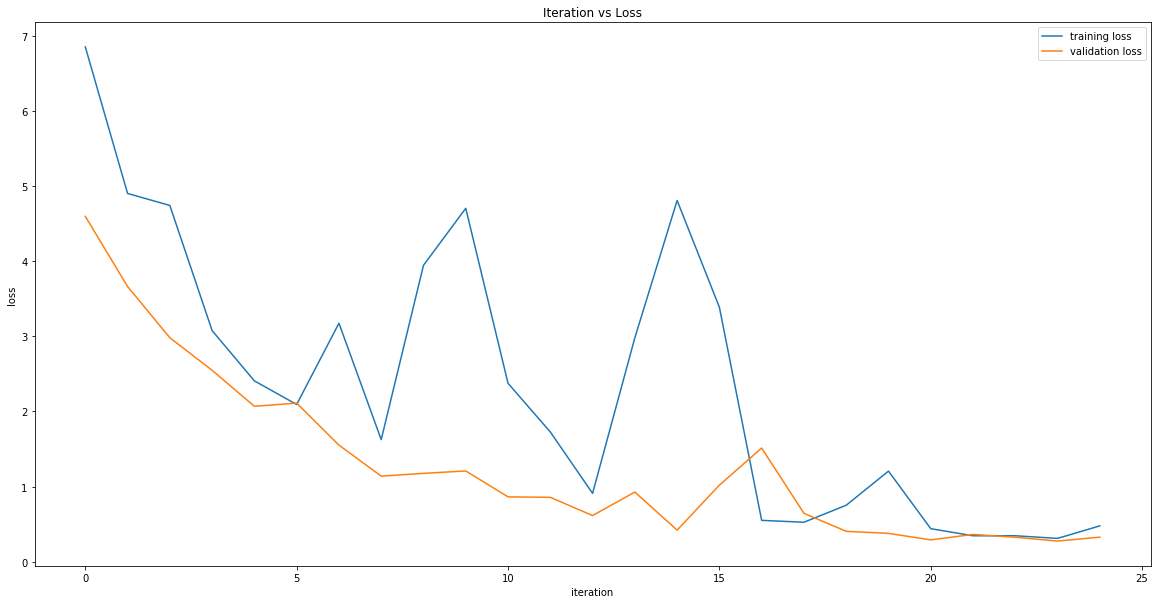

In [418]:
plot_losses(losses_tr_1, losses_va_1, count=25)

### 5.1.3 Some model generated embedding metrics (model 1)

In [431]:
show_dist_model_stats(model_1,data_set_all)

SHOWING SIMILAR
---
alltime max(max) = 1.2231085300445557
alltime min(max) = 0.3888115882873535
mean of max      = 0.8746362328529358

alltime min(min) = 0.025166723877191544
alltime max(min) = 0.5558397769927979
mean of min      = 0.2100798338651657

overall mean     = 0.4894081950187683

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9818342924118042
alltime min(max) = 1.7782797813415527
mean of max      = 1.9164772033691406

alltime min(min) = 0.7634231448173523
alltime max(min) = 1.3869014978408813
mean of min      = 1.2018256187438965

overall mean     = 1.6433221101760864



___

## 5.2 Model 2: Training without the softmax layer
- Freezing all the layers but the last linear layer (output size 512)
- Loss is calculated using the custom loss function

In [447]:
model_2 = InceptionResnetV1()

for param in model_2.parameters():
    param.requires_grad = False
    
for param in model_2.last_linear.parameters():
    param.requires_grad = True
    

optim = torch.optim.Adam(params=model_2.last_linear.parameters())
loss_func = DistLoss()

### 5.2.1 Training the model (model 2)
(Just the last linear layer, everything else is locked)

In [439]:
_, losses_tr_2, losses_va_2 = dist_fit(model_2, optim, loss_func, dataloaders[tr], dataloaders[va])

train samples: 128, valid samples: 128

EPOCH: (1/25)	0.078 s
 --------------------
train: loss 1.066, time 0 m 7.698 s
valid: loss 0.161, time 0 m 1.327 s

EPOCH: (2/25)	9.169 s
 --------------------
train: loss 0.947, time 0 m 7.679 s
valid: loss 0.117, time 0 m 1.330 s

EPOCH: (3/25)	18.245 s
 --------------------
train: loss 0.811, time 0 m 7.459 s
valid: loss 0.105, time 0 m 1.975 s

EPOCH: (4/25)	27.781 s
 --------------------
train: loss 0.748, time 0 m 9.426 s
valid: loss 0.089, time 0 m 2.063 s

EPOCH: (5/25)	39.364 s
 --------------------
train: loss 0.638, time 0 m 8.502 s
valid: loss 0.113, time 0 m 1.297 s

EPOCH: (6/25)	49.164 s
 --------------------
train: loss 0.661, time 0 m 7.386 s
valid: loss 0.090, time 0 m 1.306 s

EPOCH: (7/25)	57.856 s
 --------------------
train: loss 0.617, time 0 m 7.660 s
valid: loss 0.080, time 0 m 1.325 s

EPOCH: (8/25)	66.907 s
 --------------------
train: loss 0.504, time 0 m 8.737 s
valid: loss 0.061, time 0 m 1.400 s

EPOCH: (9/25)	77.1

In [440]:
# Copy model to a variable.
model_2_state_dict = model_2.state_dict().copy()

### 5.2.2 Plotting the losses (model 2)

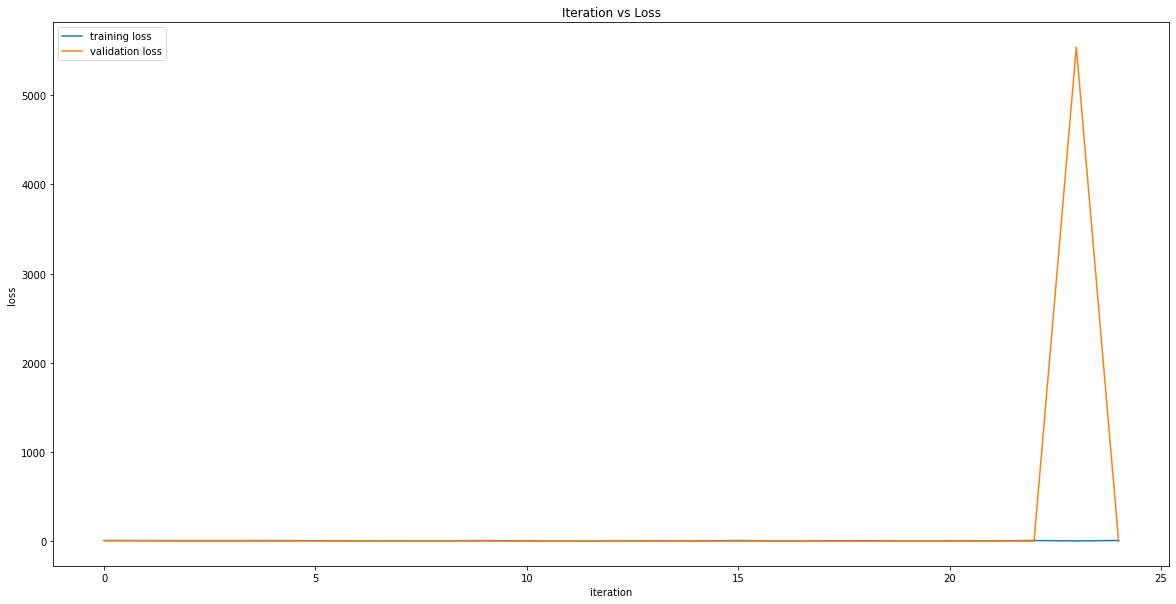

In [441]:
plot_losses(losses_tr_2, losses_va_2, count=25)

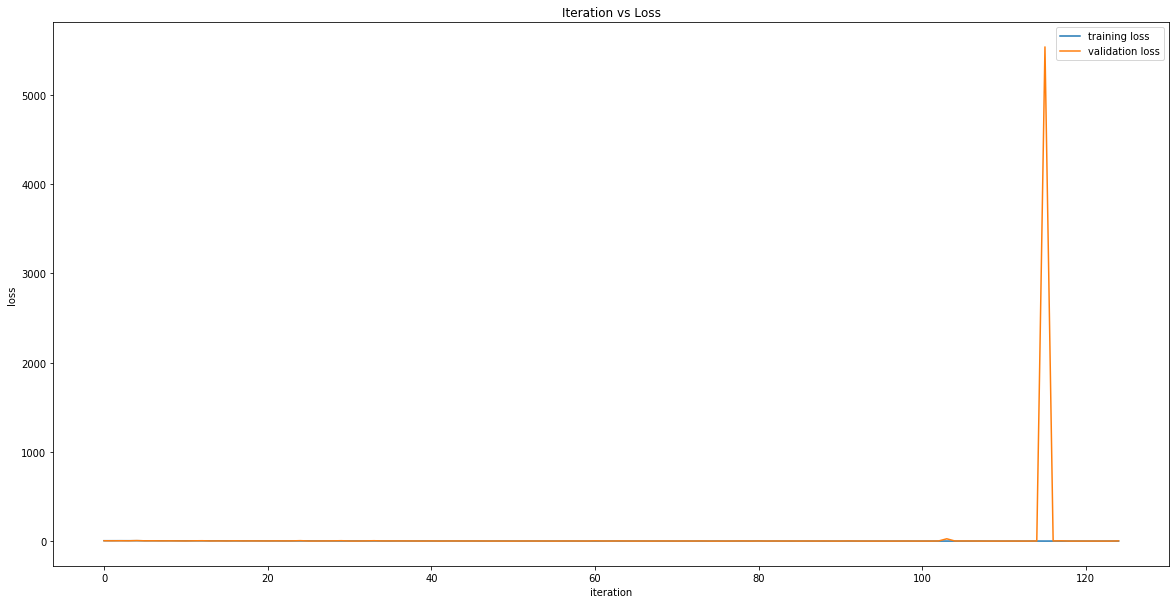

In [442]:
plot_losses(losses_va_1,losses_va_2, count=125)

### 5.2.3 Some model generated embedding metrics (model 2)

In [443]:
show_dist_model_stats(model_2,data_set_all)

SHOWING SIMILAR
---
alltime max(max) = 1.9446214437484741
alltime min(max) = 0.281996488571167
mean of max      = 0.967888593673706

alltime min(min) = 0.005791295785456896
alltime max(min) = 0.3464949429035187
mean of min      = 0.07248219102621078

overall mean     = 0.20702676475048065

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9979077577590942
alltime min(max) = 1.903033971786499
mean of max      = 1.9902845621109009

alltime min(min) = 0.18618565797805786
alltime max(min) = 0.9472010135650635
mean of min      = 0.3850319981575012

overall mean     = 1.5708911418914795



## Conclusion
- The custom loss function gives a more extreme model evident from the stats
- Need to retrain while checking other parameters of the loss function.

# 6. Checking model 2 out with different custom loss parameters

In [445]:
"""
Default values:
    sim_thresh=0.2
    dis_offset=0.3
    eps=1.2
"""
custom_loss_functions = [
    DistLoss(sim_thresh=0.1,dis_offset=0.3,eps=1.2), 
    DistLoss(sim_thresh=0.2,dis_offset=0.6,eps=1.2),
    DistLoss(sim_thresh=0.2,dis_offset=0.3,eps=1.0),
    DistLoss(sim_thresh=0.2,dis_offset=0.3,eps=0.8),
    DistLoss(sim_thresh=0.1,dis_offset=0.6,eps=0.6),
    DistLoss(sim_thresh=0.2,dis_offset=0.3,eps=1.5),
    DistLoss(sim_thresh=0.01,dis_offset=0.8,eps=0.5)
]

In [450]:
models = []
losses = []

for i,loss_func in enumerate(custom_loss_functions):
    print(f"#{i} {'_'*47}")
    
    # Model Initialization
    model = InceptionResnetV1()
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    # Thaw last layer
    for param in model.last_linear.parameters():
        param.requires_grad = True
    optim = torch.optim.Adam(params=model.last_linear.parameters())
    # Train
    _, losses_tr, losses_va = dist_fit(model, optim, loss_func, dataloaders[tr], dataloaders[va])
    
    # Save model and losses
    models.append(model.state_dict().copy())
    losses.append((losses_tr, losses_va))
    
    print(f"outcome of {loss_func.sim_thresh} {loss_func.dis_offset} {loss_func.eps}:")
    show_dist_model_stats(model,data_set_all)
    print('_'*50)

#0 _______________________________________________
train samples: 128, valid samples: 128

EPOCH: (1/25)	0.069 s
 --------------------
train: loss 1.116, time 0 m 7.901 s
valid: loss 0.155, time 0 m 1.375 s

EPOCH: (2/25)	9.441 s
 --------------------
train: loss 0.825, time 0 m 7.801 s
valid: loss 0.123, time 0 m 1.556 s

EPOCH: (3/25)	18.969 s
 --------------------
train: loss 0.766, time 0 m 7.657 s
valid: loss 0.097, time 0 m 1.745 s

EPOCH: (4/25)	28.438 s
 --------------------
train: loss 0.648, time 0 m 7.740 s
valid: loss 0.081, time 0 m 1.602 s

EPOCH: (5/25)	37.850 s
 --------------------
train: loss 0.619, time 0 m 7.996 s
valid: loss 0.058, time 0 m 1.334 s

EPOCH: (6/25)	47.249 s
 --------------------
train: loss 0.621, time 0 m 7.491 s
valid: loss 0.057, time 0 m 1.327 s

EPOCH: (7/25)	56.133 s
 --------------------
train: loss 0.628, time 0 m 8.282 s
valid: loss 0.111, time 0 m 1.827 s

EPOCH: (8/25)	66.244 s
 --------------------
train: loss 0.501, time 0 m 9.117 s
vali

train: loss 0.586, time 0 m 7.709 s
valid: loss 0.068, time 0 m 1.312 s

EPOCH: (7/25)	56.571 s
 --------------------
train: loss 0.573, time 0 m 7.541 s
valid: loss 0.044, time 0 m 1.325 s

EPOCH: (8/25)	65.503 s
 --------------------
train: loss 0.491, time 0 m 7.896 s
valid: loss 0.039, time 0 m 1.345 s

EPOCH: (9/25)	74.811 s
 --------------------
train: loss 0.503, time 0 m 8.285 s
valid: loss 0.048, time 0 m 1.481 s

EPOCH: (10/25)	84.578 s
 --------------------
train: loss 0.415, time 0 m 8.403 s
valid: loss 0.048, time 0 m 1.343 s

EPOCH: (11/25)	94.324 s
 --------------------
train: loss 0.424, time 0 m 7.963 s
valid: loss 0.039, time 0 m 1.646 s

EPOCH: (12/25)	104.017 s
 --------------------
train: loss 0.457, time 0 m 8.014 s
valid: loss 0.037, time 0 m 1.388 s

EPOCH: (13/25)	113.489 s
 --------------------
train: loss 0.338, time 0 m 8.273 s
valid: loss 0.032, time 0 m 1.466 s

EPOCH: (14/25)	123.303 s
 --------------------
train: loss 0.400, time 0 m 7.998 s
valid: loss 

train: loss 0.470, time 0 m 7.852 s
valid: loss 0.065, time 0 m 1.594 s

EPOCH: (13/25)	114.546 s
 --------------------
train: loss 0.447, time 0 m 8.226 s
valid: loss 0.050, time 0 m 1.362 s

EPOCH: (14/25)	124.211 s
 --------------------
train: loss 0.544, time 0 m 7.568 s
valid: loss 0.104, time 0 m 1.326 s

EPOCH: (15/25)	133.106 s
 --------------------
train: loss 0.606, time 0 m 7.642 s
valid: loss 0.055, time 0 m 1.322 s

EPOCH: (16/25)	142.071 s
 --------------------
train: loss 0.421, time 0 m 7.667 s
valid: loss 0.071, time 0 m 1.349 s

EPOCH: (17/25)	151.087 s
 --------------------
train: loss 0.433, time 0 m 7.610 s
valid: loss 0.085, time 0 m 1.341 s

EPOCH: (18/25)	160.039 s
 --------------------
train: loss 0.425, time 0 m 8.763 s
valid: loss 0.088, time 0 m 1.453 s

EPOCH: (19/25)	170.256 s
 --------------------
train: loss 0.532, time 0 m 8.404 s
valid: loss 0.093, time 0 m 1.347 s

EPOCH: (20/25)	180.008 s
 --------------------
train: loss 0.439, time 0 m 7.666 s
vali

train: loss 0.645, time 0 m 7.803 s
valid: loss 0.105, time 0 m 1.388 s

EPOCH: (19/25)	166.438 s
 --------------------
train: loss 0.790, time 0 m 7.827 s
valid: loss 0.184, time 0 m 1.401 s

EPOCH: (20/25)	175.668 s
 --------------------
train: loss 0.782, time 0 m 7.789 s
valid: loss 0.099, time 0 m 1.370 s

EPOCH: (21/25)	184.896 s
 --------------------
train: loss 0.634, time 0 m 7.903 s
valid: loss 0.117, time 0 m 1.393 s

EPOCH: (22/25)	194.193 s
 --------------------
train: loss 0.557, time 0 m 7.767 s
valid: loss 0.136, time 0 m 1.388 s

EPOCH: (23/25)	203.348 s
 --------------------
train: loss 0.705, time 0 m 7.787 s
valid: loss 0.095, time 0 m 1.389 s

EPOCH: (24/25)	212.610 s
 --------------------
train: loss 0.759, time 0 m 7.789 s
valid: loss 0.174, time 0 m 1.388 s

EPOCH: (25/25)	221.788 s
 --------------------
train: loss 0.589, time 0 m 7.781 s
valid: loss 0.105, time 0 m 1.369 s

Time taken: 3 m 50.939 s
outcome of 0.01 0.8 0.5:
SHOWING SIMILAR
---
alltime max(max) 